# **Amazon Employee Access Challenge (Part-2)**

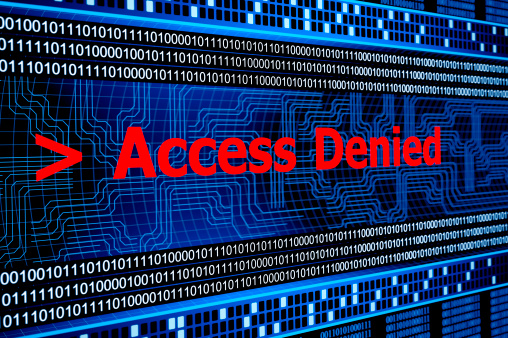

In [ ]:
#Importing libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import sparse
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [ ]:
#Installing category encoders

!pip install category_encoders

In [ ]:
#Reading data
data = pd.read_csv('../input/amazon-employee-access-challenge/train.csv')
data_test = pd.read_csv('../input/amazon-employee-access-challenge/test.csv')

# Feature Engineering

In [ ]:
Y = data['ACTION']
X = data.drop('ACTION', axis = 1)

#Dropping ROLE_CODE feature.
X = X.drop('ROLE_CODE', axis = 1)

X_test = data_test.drop('ROLE_CODE', axis = 1)
X_test = X_test.drop('id', axis = 1)

In [ ]:
X_test.head()

In [ ]:
X_test.columns

## Hybrid Features

Since these features are already encoded randomly and they are nominal features. So, adding, subtracting the feature values won't help much. However we can try concatenating them with each other. 

In [ ]:
n = len(X.columns)
print(f"We can {n} no. of features.")

In [ ]:
from tqdm import tqdm
from itertools import combinations

def concat_features_duplet(df_train, cols):
    dup_features = []
    for indicies in combinations(range(len(cols)), 2):
        dup_features.append([hash(tuple(v)) for v in df_train[:,list(indicies)]])
    return np.array(dup_features).T

In [ ]:
def concat_features_triplet(df_train, cols):
    tri_features = []
    for indicies in combinations(range(len(cols)), 3):
        tri_features.append([hash(tuple(v)) for v in df_train[:,list(indicies)]])
    return np.array(tri_features).T

Let's add feature category frequencies as well.

In [ ]:
from collections import Counter

def category_freq(X):
    X_new = X.copy()
    for f in X_new.columns:
        col_count = dict(Counter(X_new[f].values))

        for r in X_new.itertuples():
            X_new.at[r[0], f'{f}_freq'] = col_count[X_new.loc[r[0], f]]
    return X_new

In [ ]:
X.nunique()

In [ ]:
X_dup_train = concat_features_duplet(np.array(X), ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'])

X_tri_train = concat_features_triplet(np.array(X), ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'])

In [ ]:
X_dup_test = concat_features_duplet(np.array(X_test), ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'])

X_tri_test = concat_features_triplet(np.array(X_test), ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY'])

In [ ]:
from category_encoders import OrdinalEncoder

X_dup_all = np.vstack((X_dup_train, X_dup_test))
X_tri_all = np.vstack((X_tri_train, X_tri_test))

enc = OrdinalEncoder().fit(X_dup_all)
X_dup_train = enc.transform(X_dup_train)
X_dup_test = enc.transform(X_dup_test)

enc1 = OrdinalEncoder().fit(X_tri_all)
X_tri_train = enc1.transform(X_tri_train)
X_tri_test = enc1.transform(X_tri_test)

import pickle
#Saving pickle file for one-hot encoding
with open('lab_dup.pickle', 'wb') as f:
    pickle.dump(enc, f)

with open('lab_tri.pickle', 'wb') as g:
    pickle.dump(enc1, g)

In [ ]:
X_dup_train.shape

In [ ]:
X_freq_train = np.array(category_freq(X).iloc[:,8:])
X_freq_test = np.array(category_freq(X_test).iloc[:,8:])

In [ ]:
X_freq_train.shape

Combining all the original features + hybrid categorical features

In [ ]:
X_train_all_categorical = np.hstack((X, X_dup_train, X_tri_train))
X_test_all_categorical = np.hstack((X_test, X_dup_test, X_tri_test))

In [ ]:
X_train_all_categorical.shape

### One-Hot Encoding all categorical variables

We are using One-Hot Encoding only here since it worked best with our base model.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()
one_hot.fit(np.vstack((X_train_all_categorical, X_test_all_categorical)))
X_train_cat_one_enc = one_hot.transform(X_train_all_categorical)
X_test_cat_one_enc = one_hot.transform(X_test_all_categorical)

In [ ]:
X_train_cat_one_enc

### Standard Scaler for Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(np.vstack((X_freq_train, X_freq_test)))

X_train_freq = scaler.transform(X_freq_train)
X_test_freq = scaler.transform(X_freq_test)

In [ ]:
X_train_freq.shape

In [ ]:
#Saving pickle file for Standard Scaler encoding
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

### Thats all. We will have a lots of options to try with all these different encodings and hybrid features. Let's jump into the interesting part i.e. Modelling!

# Modelling

# Base Model (from Part-1 notebook)

We had a base model AUC: 0.8497 with one-hot encoding using only original features.

# Advanced Models

## 1. Logistic Regression

Let's try Logistic Regression on hybrid features this time.

We will be relying on our 10-fold Cross Validation technique to compare AUC Score.

In [ ]:
def cv_loop(X, Y, model):

  mean_auc = []
  seed = 42

  for i in range(10):

      X_train, X_cv, y_train, y_cv = train_test_split(X, Y, test_size = .20, random_state = i*seed, stratify = Y)

      # train model and make predictions
      model.fit(X_train, y_train) 
      preds = model.predict_proba(X_cv)[:, 1]

      # compute AUC metric for this CV fold
      fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
      roc_auc = metrics.auc(fpr, tpr)
      mean_auc.append(roc_auc)
      
  return np.mean(mean_auc)

In [ ]:
X_train_freq.shape

In [ ]:
#Combining all the one-hot encoded features and numerical features together.
X_train_all = sparse.hstack((X_train_freq, X_train_cat_one_enc))

for c in [ 0.01, 0.1, 1, 10]:
    auc = cv_loop(X_train_all, Y, LogisticRegression(C = c, class_weight = 'balanced'))
    print(f"For C: {c}, AUC: {auc}")

Thats a Big Improvement from our Base Model.

**Best AUC: 0.8825**

### Forward Feature Selection

In [ ]:
#One-Hot Encoding all the features seperately

X_train_one_enc_featurewise = []
X_test_one_enc_featurewise = []

for k in range(X_train_all_categorical.shape[1]):
    one_hot = OneHotEncoder()
    one_hot.fit(np.vstack((X_train_all_categorical[:, [k]], X_test_all_categorical[:, [k]])))
    X_train_one_enc_featurewise.append(one_hot.transform(X_train_all_categorical[:, [k]]))
    X_test_one_enc_featurewise.append(one_hot.transform(X_test_all_categorical[:, [k]]))

for m in range(X_train_freq.shape[1]):
    X_train_one_enc_featurewise.append(sparse.csr_matrix(X_train_freq[:, m].reshape(-1, 1)))
    X_test_one_enc_featurewise.append(sparse.csr_matrix(X_test_freq[:, m].reshape(-1, 1)))

In [ ]:
len(X_train_one_enc_featurewise)

In [ ]:
# #Forward Feature Selection (Runs very slow, hence commented)

# selected_features = []
# best_auc = [0, 0.5]

# while best_auc[-1] > best_auc[-2] and (best_auc[-1] - best_auc[-2]) > 0.01:
#     auc_scores = []

#     for idx, f in enumerate(X_train_one_enc_featurewise):

#         if idx not in selected_features:
#             feats = selected_features + [idx]
#             ft = sparse.hstack([X_train_one_enc_featurewise[j] for j in feats]).tocsr()
#             auc = cv_loop(ft, Y, LogisticRegression(C = 0.1, class_weight = 'balanced'))
#             auc_scores.append((idx, auc))

#     best_auc.append(max(auc_scores,key=lambda x:x[1])[1])
#     selected_features.append(max(auc_scores,key=lambda x:x[1])[0])

#     print(f"Feature Set: {selected_features}, AUC: {best_auc[-1]}")

Best Set of Features: [64, 42, 69, 11, 85, 0, 65, 93, 67, 29, 9, 66, 47, 60, 10, 12, 97, 71, 8, 53, 79, 19, 36, 63, 37]

AUC: 0.8928. Much improvement again.

Let's try to improve it further with hyperparameter tuning.

In [ ]:
#Saving one-hot encoder for pipeline
X_test_all_categorical_selected= X_test_all_categorical[:, [64, 42, 69, 11, 85, 0, 65, 67, 29, 9, 66, 47, 60, 10, 12, 71, 8, 53, 79, 19, 36, 63, 37, 43, 41]]
X_train_all_categorical_selected= X_train_all_categorical[:, [64, 42, 69, 11, 85, 0, 65, 67, 29, 9, 66, 47, 60, 10, 12, 71, 8, 53, 79, 19, 36, 63, 37, 43, 41]]

one_hot = OneHotEncoder()
one_hot.fit(np.vstack((X_train_all_categorical_selected, X_test_all_categorical_selected)))

with open('one_hot.pickle', 'wb') as f:
    pickle.dump(one_hot, f)

### Hyper Parameter Tuning

In [ ]:
feats = [64, 42, 69, 11, 85, 0, 65, 93, 67, 29, 9, 66, 47, 60, 10, 12, 97, 71, 8, 53, 79, 19, 36, 63, 37, 43, 99, 41]
fts = sparse.hstack([X_train_one_enc_featurewise[j] for j in feats]).tocsr()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

seed = 42

for n in [0.01, 0.1, 0.5, 1, 10]:

    mean_auc = []

    for i in range(10):

        logreg = LogisticRegression(C = n, class_weight = 'balanced')
        X_train, X_cv, y_train, y_cv = train_test_split(fts, Y, test_size = .20, random_state = i*seed, stratify = Y)

        # train model and make predictions
        logreg.fit(X_train, y_train) 
        preds = logreg.predict_proba(X_cv)[:, 1]

        # compute AUC metric for this CV fold
        fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
        roc_auc = metrics.auc(fpr, tpr)
        mean_auc.append(roc_auc)

    print(f"For C: {n}, AUC = {np.mean(mean_auc)}")

### For C = 0.5 we get best AUC Score of 0.8943.

Let's make a submission to see our standing on the leaderboard.

In [ ]:
fts_test = sparse.hstack([X_test_one_enc_featurewise[j] for j in feats]).tocsr()

In [ ]:
fts.shape

In [ ]:
fts_test.shape

In [ ]:
model = LogisticRegression(C = 0.5)

# train model and make predictions
model.fit(fts, Y) 
preds = model.predict_proba(fts_test)[:, 1]

In [ ]:
submission = pd.DataFrame(preds, columns = ['Action'])

submission['Id'] = range(1, len(preds)+1)

In [ ]:
submission.to_csv('logreg_with_FFSelection_updated.csv', index = False)

In [ ]:
#Saving model weights
filename = 'logreg1.sav'
pickle.dump(model, open(filename, 'wb'))

### AUC on Public LeaderBoard: 0.90520 and on Private LeaderBoard: 0.89930
Which is Top 15%.

## 2. Random Forest

In [ ]:
#Our selected Train and Test Features
print(fts.shape)
print(fts_test.shape)
print(Y.shape)

In [ ]:
#Random Forest works better with lesser number of features and numerical features.
#Here we are using Stratified Cross Validation as our Cross Validation Technique
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

mean_auc = []

for train_index,test_index in kf.split(X_freq_train, Y):

    X_train = X_freq_train[train_index, :]
    y_train = Y.iloc[train_index]
    X_cv = X_freq_train[test_index, :]
    y_cv = Y.iloc[test_index]

    rf = RandomForestClassifier(n_jobs = -1)
    rf.fit(X_train, y_train)
    preds = rf.predict_proba(X_cv)[:, 1]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)
    mean_auc.append(roc_auc)

print(f"AUC Score from Random Forest: {np.mean(mean_auc)}")

### Hyper Parameter Tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = 'roc_auc')
# Fit the random search model
rf_random.fit(X_freq_train, Y)

In [ ]:
rf_random.best_score_

In [ ]:
rf_random.best_params_

## 3. CatBoost Classifier

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

X_train_all = np.hstack((X_train_all_categorical, X_train_freq))
X_train_all = X_train_all.astype('int32')
X_train_all = pd.DataFrame(data=X_train_all, columns=list(range(100)))
X_train_all = X_train_all[feats]

X_test_all = np.hstack((X_test_all_categorical, X_test_freq))
X_test_all = X_test_all.astype('int32')
X_test_all = pd.DataFrame(data=X_test_all, columns=list(range(100)))
X_test_all = X_test_all[feats]

X_train, X_cv, Y_train, Y_cv = train_test_split(X_train_all, Y, test_size = 0.2, random_state = 42, stratify = Y)

cat_features = list(range(25))

model = CatBoostClassifier(custom_metric=['AUC'], early_stopping_rounds=100, eval_metric='AUC')

model.fit(X_train, Y_train, cat_features=cat_features, plot=True, verbose=False, use_best_model=True, eval_set = (X_cv, Y_cv))

In [ ]:
preds = model.predict_proba(X_cv)[:, 1]

# compute AUC metric for this CV fold
fpr, tpr, thresholds = metrics.roc_curve(Y_cv, preds)
roc_auc = metrics.auc(fpr, tpr)

In [ ]:
roc_auc

In [ ]:
feat_imp=model.get_feature_importance(prettified=True)
plt.bar(feat_imp['Feature Id'], feat_imp['Importances'])
plt.xlabel('Features')
plt.ylabel('Feature Importance')

Surprising Results! CatBoost Classifier really performs very well with categorical dataset.

## 4. ExtraTrees Classifier

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

for train_index,test_index in kf.split(X_train_all_categorical, Y):

    X_train = X_train_all_categorical[train_index,:]
    y_train = Y.iloc[train_index]
    X_cv = X_train_all_categorical[test_index,:]
    y_cv = Y.iloc[test_index]

    rf = ExtraTreesClassifier(n_jobs = -1)
    rf.fit(X_train, y_train)
    preds = rf.predict_proba(X_cv)[:, 1]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)

    print(f"AUC: {roc_auc}")

ExtraTrees Classifier gives AUC of around 0.84.

## 5. KNN

Trying Stratified K-Fold CV

In [ ]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)

for k in [5, 8, 11, 22, 55, 111, 1111]:
    mean_auc = []

    knn = KNeighborsClassifier(n_neighbors=k)

    for train_index,test_index in kf.split(fts, Y):

        X_train = fts[train_index, :]
        y_train = Y.iloc[train_index]
        X_cv = fts[test_index, :]
        y_cv = Y.iloc[test_index]

        knn.fit(X_train, y_train) 
        preds = knn.predict_proba(X_cv)[:, 1]

        # compute AUC metric for this CV fold
        fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
        roc_auc = metrics.auc(fpr, tpr)

        mean_auc.append(roc_auc)
    print(f"AUC for n= {k}: {np.mean(mean_auc)}")

For KNN: n_neighbours = 11 is giving the best results.

## 6. XGBoost

In [ ]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [ ]:
## Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

classifier=xgboost.XGBClassifier()

random_search=RandomizedSearchCV(classifier, param_distributions=params, n_iter=100, scoring='roc_auc', n_jobs=-1, cv=3, verbose=3)

random_search.fit(X_freq_train,Y)

In [ ]:
random_search.best_score_

In [ ]:
random_search.best_estimator_

Best XGBoost Estimator is giving AUC: 0.856

We will be using this best XGBoost estimator in stacking.

# Stacking

We are using 5 first level models here: Logistic Regression, Random Forest, CatBoost Classifier, ExtraTrees Classifier, KNN and XGBoost.

And second level model: Logistic Regression

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

y_pred_dataframe_cv = pd.DataFrame()
y_pred_dataframe_test = pd.DataFrame()

seed = 42
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
cat_features = list(range(25))

cat = CatBoostClassifier(custom_metric=['AUC'], early_stopping_rounds=100, eval_metric='AUC')
model = LogisticRegression(C = 0.5, class_weight = 'balanced')
rf = RandomForestClassifier(n_estimators = 400, min_samples_split = 10, min_samples_leaf = 2, max_features = 'auto', max_depth = 20, bootstrap = False, n_jobs = -1)
extc = ExtraTreesClassifier(n_jobs = -1) 
knn = KNeighborsClassifier(n_neighbors = 11)

mean_auc_log = []
mean_auc_rf = []
mean_auc_cat = []
mean_auc_ext = []
mean_auc_knn = []

for train_index,test_index in kf.split(fts, Y):
    
    #Logistic Regression
    X_train = fts[train_index,:]
    y_train = Y.iloc[train_index]
    X_cv = fts[test_index,:]
    y_cv = Y.iloc[test_index]

    # train model and make predictions
    model.fit(X_train, y_train) 
    preds = model.predict_proba(X_cv)[:, 1]

    for idx, k in enumerate(test_index):
        y_pred_dataframe_cv.at[k, 'Id'] = k
        y_pred_dataframe_cv.at[k, 'Logistic Regression'] = preds[idx]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)

    mean_auc_log.append(roc_auc)

    #Random Forest
    X_train_rf = X_freq_train[train_index, :]
    y_train_rf = Y.iloc[train_index]
    X_cv_rf = X_freq_train[test_index, :]
    y_cv_rf = Y.iloc[test_index]

    # train model and make predictions
    rf.fit(X_train_rf, y_train_rf) 
    rf_preds = rf.predict_proba(X_cv_rf)[:, 1]

    for idx, k in enumerate(test_index):
        y_pred_dataframe_cv.at[k, 'Random Forest'] = rf_preds[idx]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv_rf, rf_preds)
    roc_auc = metrics.auc(fpr, tpr)

    mean_auc_rf.append(roc_auc)
    
    #CatBoost Classifier
    X_train_cat = X_train_all.iloc[train_index]
    y_train_cat = Y.iloc[train_index]
    X_cv_cat = X_train_all.iloc[test_index]
    y_cv_cat = Y.iloc[test_index]

    # train model and make predictions
    cat.fit(X_train_cat, y_train_cat, cat_features=cat_features, eval_set=(X_cv_cat, y_cv_cat), plot=True, verbose=False, use_best_model=True)

    cat_preds = cat.predict_proba(X_cv_cat)[:, 1]

    for idx, k in enumerate(test_index):
        y_pred_dataframe_cv.at[k, 'CatBoost'] = cat_preds[idx]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv_cat, cat_preds)
    roc_auc = metrics.auc(fpr, tpr)

    mean_auc_cat.append(roc_auc)
    
    #ExtraTrees Classifier
    X_train_ext = X_train_all_categorical[train_index,:]
    y_train_ext = Y.iloc[train_index]
    X_cv_ext = X_train_all_categorical[test_index,:]
    y_cv_ext = Y.iloc[test_index]

    # train model and make predictions
    extc.fit(X_train_ext, y_train_ext)

    extc_preds = extc.predict_proba(X_cv_ext)[:, 1]

    for idx, k in enumerate(test_index):
        y_pred_dataframe_cv.at[k, 'ExtraTrees Classifier'] = extc_preds[idx]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv_ext, extc_preds)
    roc_auc = metrics.auc(fpr, tpr)

    mean_auc_ext.append(roc_auc)
    
    #KNN
    X_train = fts[train_index,:]
    y_train = Y.iloc[train_index]
    X_cv = fts[test_index,:]
    y_cv = Y.iloc[test_index]

    # train model and make predictions
    knn.fit(X_train, y_train) 
    preds = knn.predict_proba(X_cv)[:, 1]

    for idx, k in enumerate(test_index):
        y_pred_dataframe_cv.at[k, 'Id'] = k
        y_pred_dataframe_cv.at[k, 'KNN'] = preds[idx]

    # compute AUC metric for this CV fold
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
    roc_auc = metrics.auc(fpr, tpr)

    mean_auc_knn.append(roc_auc)

print(f"AUC for Logistic Regression: {np.mean(mean_auc_log)}")
print(f"AUC for Random Forest: {np.mean(mean_auc_rf)}")
print(f"AUC for CatBoost Classifier: {np.mean(mean_auc_cat)}")
print(f"AUC for ExtraTrees Classifier: {np.mean(mean_auc_ext)}")
print(f"AUC for KNN: {np.mean(mean_auc_knn)}")

preds_test = model.predict_proba(fts_test)[:, 1]
rf_preds_test = rf.predict_proba(X_freq_test)[:, 1]
cat_preds_test = cat.predict_proba(X_test_all)[:, 1]
extc_preds_test = extc.predict_proba(X_test_all_categorical)[:, 1]
knn_preds_test = knn.predict_proba(fts_test)[:, 1]

for idx, k in enumerate(preds_test):
    y_pred_dataframe_test.at[idx, 'CatBoost'] = cat_preds_test[idx]
    y_pred_dataframe_test.at[idx, 'Random Forest'] = rf_preds_test[idx]
    y_pred_dataframe_test.at[idx, 'Logistic Regression'] = preds_test[idx]
    y_pred_dataframe_test.at[idx, 'ExtraTrees Classifier'] = extc_preds_test[idx]
    y_pred_dataframe_test.at[idx, 'KNN'] = knn_preds_test[idx]

In [ ]:
y_pred_dataframe_cv.sort_index(axis = 0, inplace= True)

In [ ]:
y_pred_dataframe_cv = y_pred_dataframe_cv.drop('Id', axis = 1)

In [ ]:
sns.heatmap(y_pred_dataframe_cv.corr())

Bad News! Looks like Our 2 best models i.e. Logistic Regression and CatBoost Classifier are correlated. XGBoost and Random Forest results are also correlated.

Let's hope for the best.

In [ ]:
y_pred_dataframe_test.to_csv('test_stack.csv', index = False)

In [ ]:
y_pred_dataframe_cv.to_csv('cv_stack.csv', index = False)

In [ ]:
y_pred_dataframe_cv.head()

We have got our meta-features.

## Final Submission

Using Logistic Regression as a Meta-Model and fitting it on our Meta Features obtained from other first level classifiers. 

And later hyperparameter tuning it.

In [ ]:
for c in [0.0001, 0.00001, 0.001, 0.01, 0.1, 1]:
    mean_auc = []

    for i in range(10):

        seed = 42
        kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=i*seed)

        for train_index,test_index in kf.split(y_pred_dataframe_cv, Y):
            X_train = y_pred_dataframe_cv.iloc[train_index]
            y_train = Y.iloc[train_index]
            X_cv = y_pred_dataframe_cv.iloc[test_index]
            y_cv = Y.iloc[test_index]

            stack = LogisticRegression(C = c)
            stack.fit(X_train, y_train)
            preds = stack.predict_proba(X_cv)[:, 1]

            # compute AUC metric for this CV fold
            fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
            roc_auc = metrics.auc(fpr, tpr)

            mean_auc.append(roc_auc)

    print(f"For C: {c}, AUC: {np.mean(mean_auc)}")

#### C = 0.1 gives the best AUC Score of 0.8971

## Forward Feature Selection

In [ ]:
stack_featurewise=[]

for f in y_pred_dataframe_cv.columns:
    stack_featurewise.append(y_pred_dataframe_cv[f].values)

In [ ]:
#Forward Feature Selection

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

selected_features = []
best_auc = [0, 0.5]

while best_auc[-1] > best_auc[-2]:
    auc_scores = []

    for idx, f in enumerate(stack_featurewise):

        if idx not in selected_features:
            feats = selected_features + [idx]
            ft = np.hstack([stack_featurewise[j].reshape(-1, 1) for j in feats])
            auc = cv_loop(ft, Y, LogisticRegression(C = 0.1, class_weight = 'balanced'))
            auc_scores.append((idx, auc))

    best_auc.append(max(auc_scores,key=lambda x:x[1])[1])
    selected_features.append(max(auc_scores,key=lambda x:x[1])[0])

    print(f"Feature Set: {selected_features}, AUC: {best_auc[-1]}")

As expected, Logistic Regression and CatBoost Classifier gave best scores above also. And here also we can see that feature 2, 0 are from those classifiers only.

## HyperParameter Tuning again on Selected Features

In [ ]:
y_pred_dataframe_cv_selected = y_pred_dataframe_cv.iloc[:, [2, 0]]
y_pred_dataframe_test_selected = y_pred_dataframe_test.iloc[:, [2, 0]]

In [ ]:
for c in [0.0001, 0.00001, 0.001, 0.01, 0.1, 1]:
    mean_auc = []

    for i in range(10):

        seed = 42
        kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=i*seed)

        for train_index,test_index in kf.split(y_pred_dataframe_cv_selected, Y):
            X_train = y_pred_dataframe_cv_selected.iloc[train_index]
            y_train = Y.iloc[train_index]
            X_cv = y_pred_dataframe_cv_selected.iloc[test_index]
            y_cv = Y.iloc[test_index]

            stack = LogisticRegression(C = c, class_weight = 'balanced')
            stack.fit(X_train, y_train)
            preds = stack.predict_proba(X_cv)[:, 1]

            # compute AUC metric for this CV fold
            fpr, tpr, thresholds = metrics.roc_curve(y_cv, preds)
            roc_auc = metrics.auc(fpr, tpr)

            mean_auc.append(roc_auc)

    print(f"For C: {c}, AUC: {np.mean(mean_auc)}")

### C = 0.00001 is best with AUC Score of 0.89739

Let's check our predictions plot.

In [ ]:
plt.figure(figsize=(8, 8))
sns.distplot(preds-0.5)
plt.xlabel('[Probabilities - 0.5] Values')
plt.ylabel('Probabilities')
plt.title('Probabilities Distribution')

We can see the data imbalance here. Very less datapoints are predicted as class 0 compared to class 1.

## Final Submission: Stacked Model with Selected Features

In [ ]:
stack = LogisticRegression(C = 0.00001, class_weight = 'balanced')
stack.fit(y_pred_dataframe_cv_selected, Y) 

stack_preds = stack.predict_proba(y_pred_dataframe_test_selected)[:, 1]

submission = pd.DataFrame(stack_preds, columns = ['Action'])
submission['Id'] = range(1, len(stack_preds)+1)

submission.to_csv('cat + log + rf + xt+ knn_final_02-07.csv', index = False)

In [ ]:
submission.head()

### Meh. Private AUC: 0.89837, Public AUC: 0.90338

AUC has dropped a little.




# Summary

In [ ]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Cross Validation AUC", "Submission- Public AUC"]

x.add_row(["Base Model: Logistic Regression", 0.8497, "-"])
x.add_row(["Logistic Regression with Hybrid Features", 0.8825, "-"])
x.add_row(["Logistic Regression with Forward Feature Selection", 0.8943, 0.9052])
x.add_row(["Random Forest", 0.8575, "-"])
x.add_row(["CatBoost", 0.8961, 0.8964])
x.add_row(["ExtraTrees", 0.8560, "-"])
x.add_row(["KNN", 0.8398, "-"])
x.add_row(["XGBoost", 0.8569, "-"])
x.add_row(["Stacked Model: Logistic Regression + CatBoost Classifier", 0.8974, 0.9034])

print(x)

# Best Submission:

## AUC on Public LeaderBoard: 0.90520 and on Private LeaderBoard: 0.89930
### Which is Top 15%.

# Conclusion

This was a very interesting challenge for a begineer. I learnt alot from this exercise. Tried various encoding techniques, machine learning models and compared their performance.

Learnt more about concepts like Cross-Validation, How to handle imbalanced data, Forward Feature Selection etc.

However the AUC score can be improved further. Here are some of the keys for further improvement-

1. Stacked model not performing well due to overfitting. Possible reason might be data leakage.
2. We can hyperparameter tune Random Forest, ExtraTrees and XGBoost more rigorously.

Anyways, I will consider this as a good try as this was my first hand experience with kaggle. Its fierce!

# The End!

Thank you for reading my notebook. Hope you have learned something new from this analysis.

**Please upvote if you like it!**

Note: This notebook is from a 3 part series. Please check the other parts as well.